## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pi
from math import sqrt
from skimage import morphology
from skimage.morphology import opening
from skimage import transform
from skimage import filters

## Paths

In [2]:
IMG_PATH = '../data/example_image/'
SUPER_IMG_PATH = '../data/example_image/'
SEG_PATH = '../data/example_segmentation/'

TRUTH = '../data/example_ground_truth.csv'
FEATURES = '../features/features.csv'

## Functions

In [157]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray


def masker(image, sens):
    '''takes image and returns a masked image'''
    gray = rgb2gray(image) #create grayscale thingy
    img2 = gray < sens # **This level needs manually adjusting, also need to be able to automate**
    
    struct_el = morphology.disk(5)
    opened = opening(img2.astype(int), struct_el)
    
    return opened

def dimensions(mask):
    '''calculates height(max) and width(90 deg to height)
        returns height, width, rotated mask image, degree of rotation'''
    pixels_in_col = np.max(np.sum(mask, axis=0))

    rot = 0
    max_col = 0
    rot_max = 0
    for _ in range(9):
        rot_im = transform.rotate(mask,rot)
        pixels_in_col = np.max(np.sum(rot_im, axis=0))
        if pixels_in_col > max_col:
            max_col = pixels_in_col
            rot_max = rot
        rot += 10

    pixels_in_row = np.max(np.sum(mask1, axis=1))    
    return max_col, pixels_in_row, rot_max

def perimeter(bi_image):
    '''calcs mask perimeter, returns outline image and length of perimeter'''
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(bi_image, struct_el)
    image_perimeter = bi_image - mask_eroded

    return image_perimeter, float(np.sum(image_perimeter))

def predict(bi_image):   
    area = np.sum(bi_image)
    _, peri = perimeter(bi_image)
    
    area_from_peri = pi*((peri/(2*pi))**2)
    peri_from_area = 2*pi*sqrt(area/pi)
    
    return area, area_from_peri, peri, peri_from_area

## Import single image and create mask

(551, 693, 3)
(551, 693)


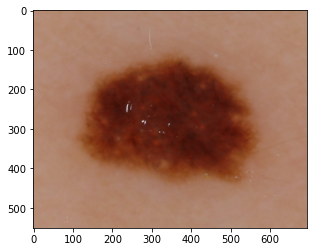

In [570]:
IMG = 'ISIC_0001852'
image = plt.imread(IMG_PATH+IMG+'.jpg')
mask1 = plt.imread(SEG_PATH+IMG+'_segmentation.png')

#plt.imshow(mask1, cmap='gray');

mask = np.where(mask1 == 1)

x_min = min(mask[0])
if x_min > 100:
    x_min -= 100
else:
    x_min = 0
y_min = min(mask[1])
if y_min > 100:
    y_min -= 100
else:
    y_min = 0
    
x_max = max(mask[0])+100
y_max = max(mask[1])+100




image = image[x_min:x_max,y_min:y_max]
mask1 = mask1[x_min:x_max,y_min:y_max]


print(image.shape)
print(mask1.shape)

plt.imshow(image, cmap='gray');

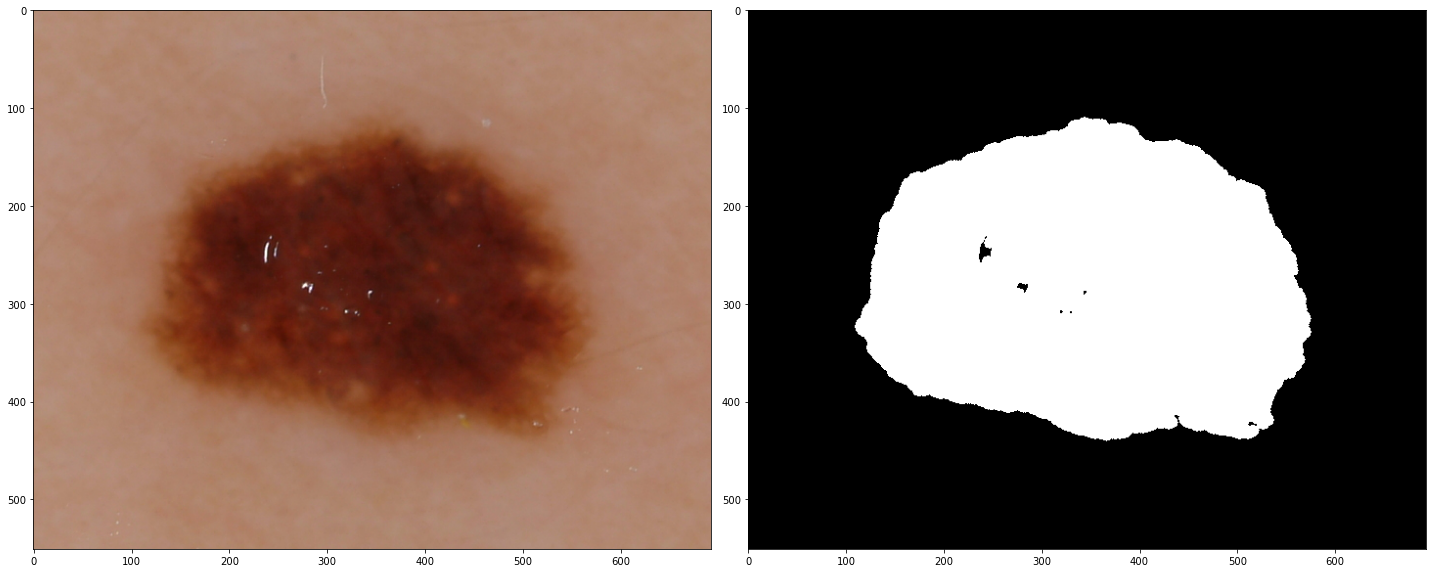

In [571]:
mask2 = masker(image, 120)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes[0].imshow(image, cmap='gray')
axes[1].imshow(mask2, cmap='gray')
fig.tight_layout()

Length: 1427.00


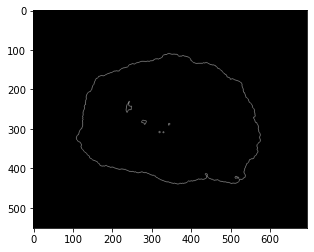

In [572]:
peri_img, peri = perimeter(mask2)

print(f'Length: {peri:.2f}')

plt.imshow(peri_img, cmap='gray');

In [303]:
truth = pd.read_csv(TRUTH)
truth.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0


In [612]:
working = truth[0:50].copy()
processed = pd.DataFrame(columns = ['id','perimeter','area', 'ref_area','ratio', 'peri', 'mask','image', 'melanoma','keratosis'])

c= 0

for image in working['image_id']:
    
    image2 = plt.imread(IMG_PATH+image+'.jpg')
    mask1 = plt.imread(SEG_PATH+image+'_segmentation.png')

    #plt.imshow(mask1, cmap='gray');

    mask = np.where(mask1 == 1)

    x_min = min(mask[0])
    if x_min > 100:
        x_min -= 100
    else:
        x_min = 0
    y_min = min(mask[1])
    if y_min > 100:
        y_min -= 100
    else:
        y_min = 0

    x_max = max(mask[0])+100
    y_max = max(mask[1])+100
    
    image3 = image2[x_min:x_max,y_min:y_max]
    
    area_1 = np.sum(mask1)
    
    mask2 = masker(image3, 120)
    area = np.sum(mask2)
    
    peri_img, peri = perimeter(mask2)
   
    processed.loc[c] = [image, peri,area, area_1, area/area_1, peri_img, mask2,image3, working[working['image_id'] == image].iloc[0]['melanoma'], working[working['image_id'] == image].iloc[0]['seborrheic_keratosis']]
    c+=1

In [613]:
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

#o_mask = plt.imread(SEG_PATH+'ISIC_0012547'+'_segmentation.png')
#o_im = plt.imread(IMG_PATH+'ISIC_0012547'+'.jpg')

#axes[0].imshow(o_im, cmap='gray')
#axes[1].imshow(o_mask,cmap='gray')
#fig.tight_layout()

In [622]:
test = -1
sorted_processed = processed.sort_values(by=['ratio'], ignore_index=True)
sorted_processed

,id,perimeter,area,ref_area,ratio,peri,mask,image,melanoma,keratosis
0,ISIC_0012335,0.0,0,169693.0,0.000000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[223, 195, 192], [223, 195, 194], [221, 193,...",0.0,0.0
1,ISIC_0012210,0.0,0,791881.0,0.000000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[184, 150, 123], [181, 150, 121], [179, 148,...",0.0,1.0
2,ISIC_0006815,0.0,0,147851.0,0.000000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[194, 160, 151], [194, 160, 150], [195, 161,...",0.0,0.0
3,ISIC_0012256,30.0,96,1071587.0,0.000090,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[189, 130, 116], [190, 131, 117], [189, 130,...",0.0,0.0
4,ISIC_0006671,28.0,81,173787.0,0.000466,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[179, 145, 135], [180, 146, 136], [180, 146,...",0.0,0.0
5,ISIC_0012160,28.0,81,109831.0,0.000737,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[179, 166, 158], [178, 165, 157], [179, 164,...",0.0,0.0
6,ISIC_0012159,69.0,246,328058.0,0.000750,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[169, 134, 128], [168, 133, 127], [170, 137,...",0.0,0.0
7,ISIC_0012254,450.0,3121,3797888.0,0.000822,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[143, 117, 116], [141, 115, 114], [144, 116,...",0.0,1.0
8,ISIC_0012380,418.0,2074,550653.0,0.003766,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[217, 184, 175], [216, 183, 174], [216, 183,...",0.0,1.0
9,ISIC_0012383,703.0,4509,1194775.0,0.003774,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[196, 155, 123], [195, 155, 120], [197, 154,...",0.0,1.0


4 ISIC_0006671 28.0 0.00046608779713097067


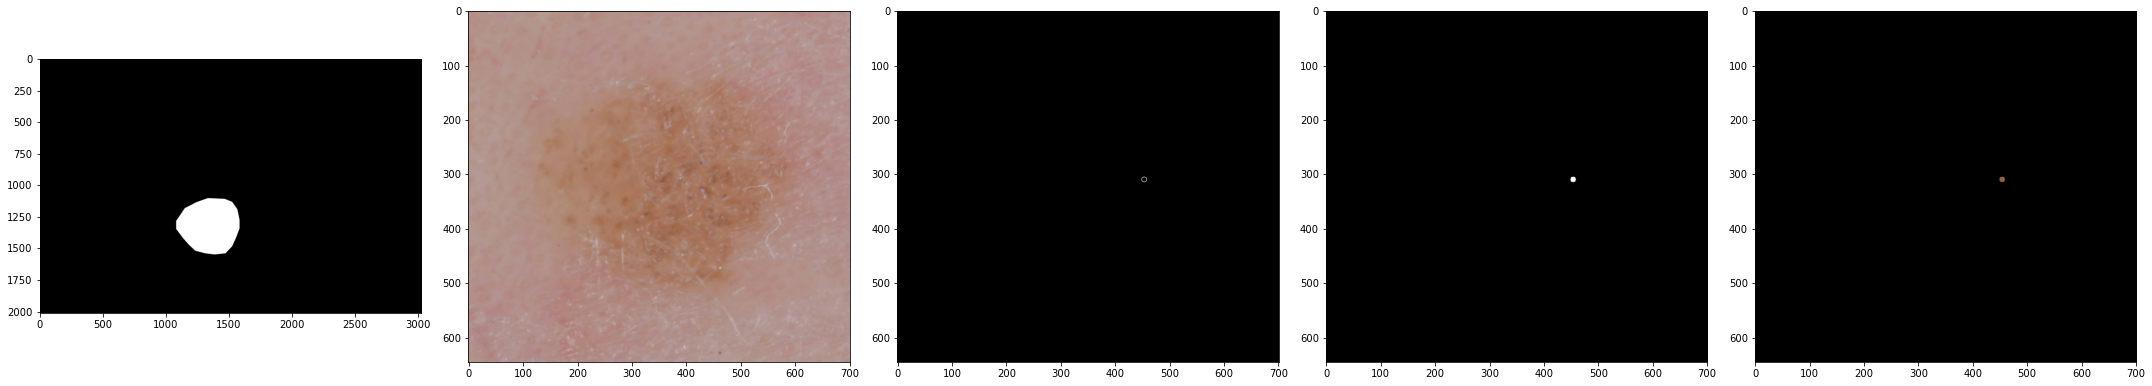

In [627]:
test = test+1

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 20))
axes.flatten()

print(test, sorted_processed['id'][test],sorted_processed['perimeter'][test], sorted_processed['ratio'][test])


o_mask = plt.imread(SEG_PATH+sorted_processed['id'][test]+'_segmentation.png')
im3 = sorted_processed['image'][test].copy()
im3[sorted_processed['mask'][test]==0] = 0

axes[1].imshow(sorted_processed['image'][test], cmap='gray')
axes[0].imshow(o_mask, cmap='gray')
axes[2].imshow(sorted_processed['peri'][test],cmap='gray')
axes[3].imshow(sorted_processed['mask'][test],cmap='gray')
axes[4].imshow(im3, cmap='gray')

fig.tight_layout();

12212224 1669033.0
13.666904570371457


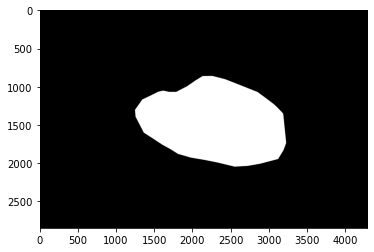

In [563]:
#Total size of the image
total = mask1.shape[0] * mask1.shape[1] 

#Size of mask only
area = np.sum(mask1)
print(total, area)
#As percentage
print(area/total*100)

plt.imshow(mask1, cmap='gray');

Height: 548.07, 
Width: 540.00


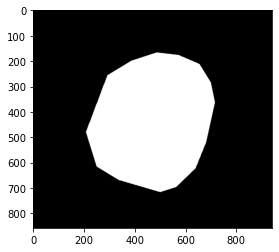

In [118]:
height, width, rot_max = dimensions(mask1)
rot_img = transform.rotate(mask1,rot_max)
print(f'Height: {height:.2f}, \nWidth: {width:.2f}')
plt.imshow(rot_img, cmap='gray');

Length: 1514.00


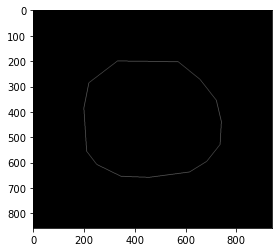

In [119]:
peri_img, peri = perimeter(mask1)

print(f'Length: {peri:.2f}')

plt.imshow(peri_img, cmap='gray');

In [104]:
rad_from_peri = peri/(2*pi)
rad_from_area = sqrt(area/pi)

est_circ = 2*pi*rad_from_area
est_area = pi*rad_from_peri**2

print(f'Difference in circumference: {abs(peri-est_circ):.2f} \nDifference in area: {abs(area-est_area):.2f}')

Difference in circumference: 3822.36 
Difference in area: 5653258.45


In [10]:
print(predict(mask1))

(216160.0, 322461.3632968713, 2013.0, 1648.1343003529412)


## Load dataframes

In [11]:
truth = pd.read_csv(TRUTH)
features = pd.read_csv(FEATURES)

truth.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0


In [12]:
cancer = truth[truth['melanoma'] == 1]
cancer.shape

(30, 3)

In [13]:
'''pred_df = pd.DataFrame(columns=['id', 'area', 'pred_area', 'peri','pred_peri','melanoma', 'seborrheic_keratosis'])

c=0
for name in truth['image_id']:
    mask1 = plt.imread(SEG_PATH+name+'_segmentation.png')
    area, pred_area, peri, pred_peri = predict(mask1)
    pred_df.loc[c] = [name, area, pred_area, peri, pred_peri,truth[truth['image_id'] == name].iloc[0]['melanoma'], truth[truth['image_id'] == name].iloc[0]['seborrheic_keratosis']]
    c+=1'''


"pred_df = pd.DataFrame(columns=['id', 'area', 'pred_area', 'peri','pred_peri','melanoma', 'seborrheic_keratosis'])\n\nc=0\nfor name in truth['image_id']:\n    mask1 = plt.imread(SEG_PATH+name+'_segmentation.png')\n    area, pred_area, peri, pred_peri = predict(mask1)\n    pred_df.loc[c] = [name, area, pred_area, peri, pred_peri,truth[truth['image_id'] == name].iloc[0]['melanoma'], truth[truth['image_id'] == name].iloc[0]['seborrheic_keratosis']]\n    c+=1"

In [14]:
#pred_df.shape

In [15]:
merged_features = features.merge(truth, left_on=['id'],right_on=['image_id'])

merged_features[25:30]

,id,area,perimeter,image_id,melanoma,seborrheic_keratosis
25,ISIC_0012099,88455.0,1353.0,ISIC_0012099,1.0,0.0
26,ISIC_0012109,129415.0,1662.0,ISIC_0012109,0.0,0.0
27,ISIC_0012126,75301.0,1262.0,ISIC_0012126,0.0,0.0
28,ISIC_0012127,106564.0,1103.0,ISIC_0012127,0.0,0.0
29,ISIC_0012143,1124326.0,5267.0,ISIC_0012143,0.0,1.0


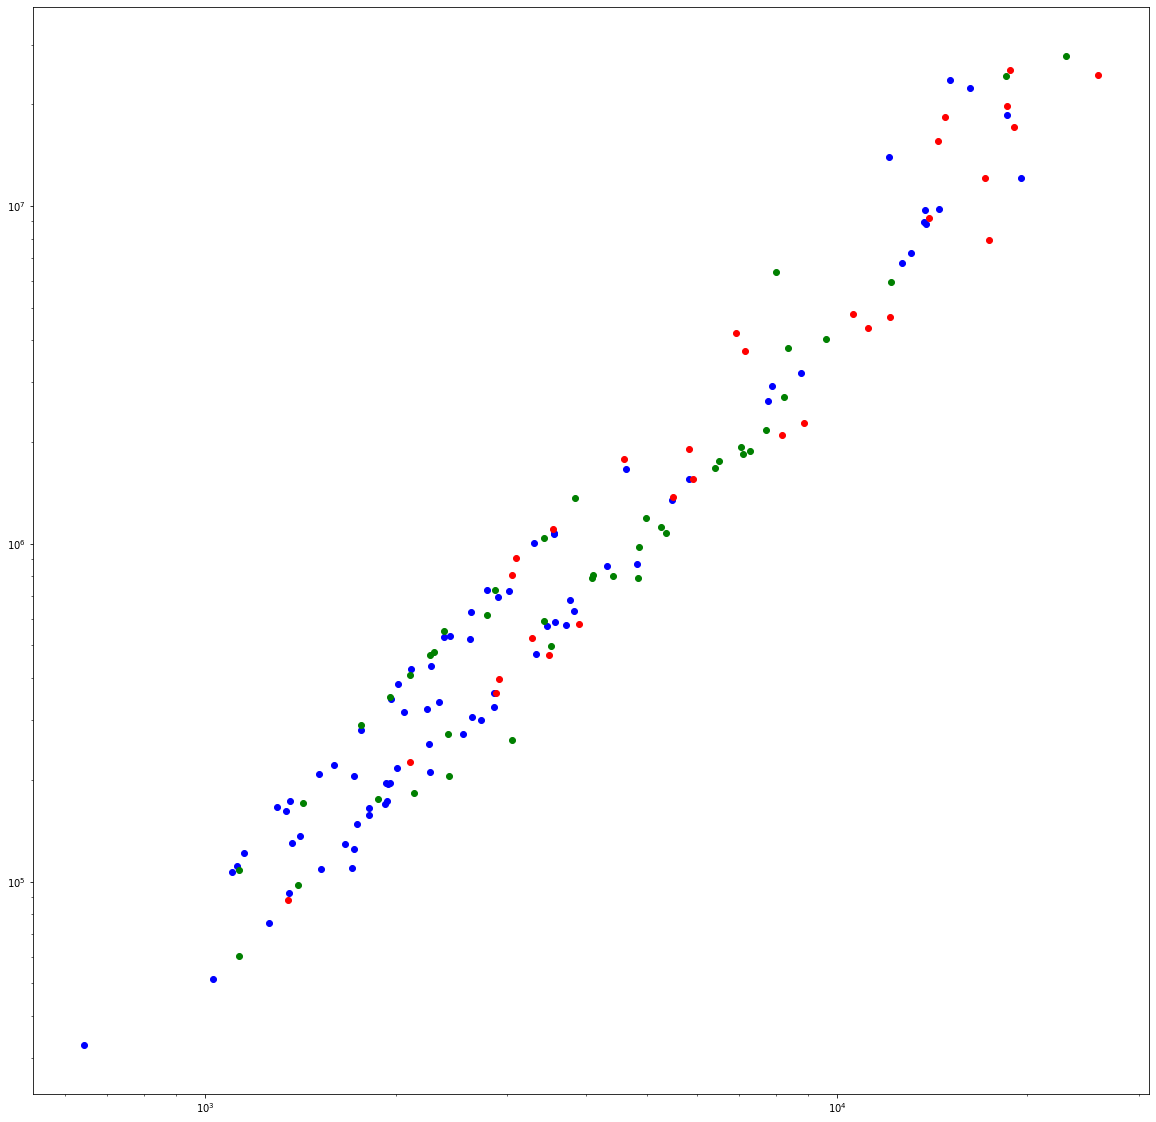

In [16]:
mel = merged_features[merged_features['melanoma']==1.0]
kera = merged_features[merged_features['seborrheic_keratosis']==1.0]
clear = merged_features[(merged_features['melanoma']==0.0) & (merged_features['seborrheic_keratosis']==0.0)]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))

plt.scatter(clear['perimeter'], clear['area'], c='blue')
plt.scatter(kera['perimeter'], kera['area'], c='green')
plt.scatter(mel['perimeter'], mel['area'], c='red');
plt.xscale('log');
plt.yscale('log');

In [17]:
'''mel = pred_df[pred_df['melanoma']==1.0]
kera = pred_df[pred_df['seborrheic_keratosis']==1.0]
clear = pred_df[(pred_df['melanoma']==0.0) & (pred_df['seborrheic_keratosis']==0.0)]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))

plt.scatter(clear['peri'], clear['pred_peri'], c='blue')
plt.scatter(kera['peri'], kera['pred_peri'], c='green')
plt.scatter(mel['peri'], mel['pred_peri'], c='red')
plt.xscale('log')
plt.yscale('log');''';

In [32]:
#Look at colour...
IMG = 'ISIC_0012254'
image = plt.imread(IMG_PATH+IMG+'.jpg')
mask1 = plt.imread(SEG_PATH+IMG+'_segmentation.png')


def colour(image, mask, show=False):
    
    rgb = image.copy()
    
    rgb[mask==0]= 0
    
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    
    area = np.sum(mask)
    
    r_av = (r.sum()/area) #average r value
    g_av = (g.sum()/area) #average g value
    b_av = (b.sum()/area) #average b value
    
    difference_r = rgb[:,:,0] - r_av #find the difference 
    difference_g = rgb[:,:,1] - g_av
    difference_b = rgb[:,:,2] - b_av
    
    difference_r[difference_r == -r_av] = 0
    difference_g[difference_g == -g_av] = 0
    difference_b[difference_b == -b_av] = 0
    
    #plt.imshow(difference_r, cmap='gray')
    #print(mask.shape, difference_r.shape)
    
    if show:
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
        axes = axes.flatten()

        axes[0].imshow(rgb)
        axes[1].imshow(r, cmap='gray')
        axes[2].imshow(g, cmap='gray')
        axes[3].imshow(b, cmap='gray')
        fig.tight_layout()
    
    return np.absolute(difference_r).sum()/area,np.absolute(difference_g).sum()/area,np.absolute(difference_b).sum()/area


r,g,b = colour(image, mask1)
print(r,g,b)

3.012164632012777 7.775332221876761 7.08308173047788


In [49]:
rgb_truth = truth.copy()
R=[]
G=[]
B=[]
T = []
c=0

for name in rgb_truth['image_id']:
    i = plt.imread(IMG_PATH+name+'.jpg')
    m = plt.imread(SEG_PATH+name+'_segmentation.png')
    
    r,g,b = colour(i, m)
    t = r+g+b
    R.append(r)
    G.append(g)
    B.append(b)
    T.append(t)
    #print((r,g,b))
    
    c+=1
    
rgb_truth.insert(0, 'r', R)
rgb_truth.insert(0, 'g', G)
rgb_truth.insert(0, 'b', B)
rgb_truth.insert(0, 't', T)

In [50]:
rgb_truth.head()

,t,b,g,r,image_id,melanoma,seborrheic_keratosis
0,41.899593,15.979759,15.645376,10.274458,ISIC_0001769,0.0,0.0
1,76.131236,20.272581,27.986815,27.871839,ISIC_0001852,0.0,0.0
2,31.971474,16.110130,10.718127,5.143216,ISIC_0001871,0.0,0.0
3,67.886850,31.511064,24.543610,11.832176,ISIC_0003462,0.0,0.0
4,73.212492,26.757442,27.995091,18.459959,ISIC_0003539,0.0,0.0


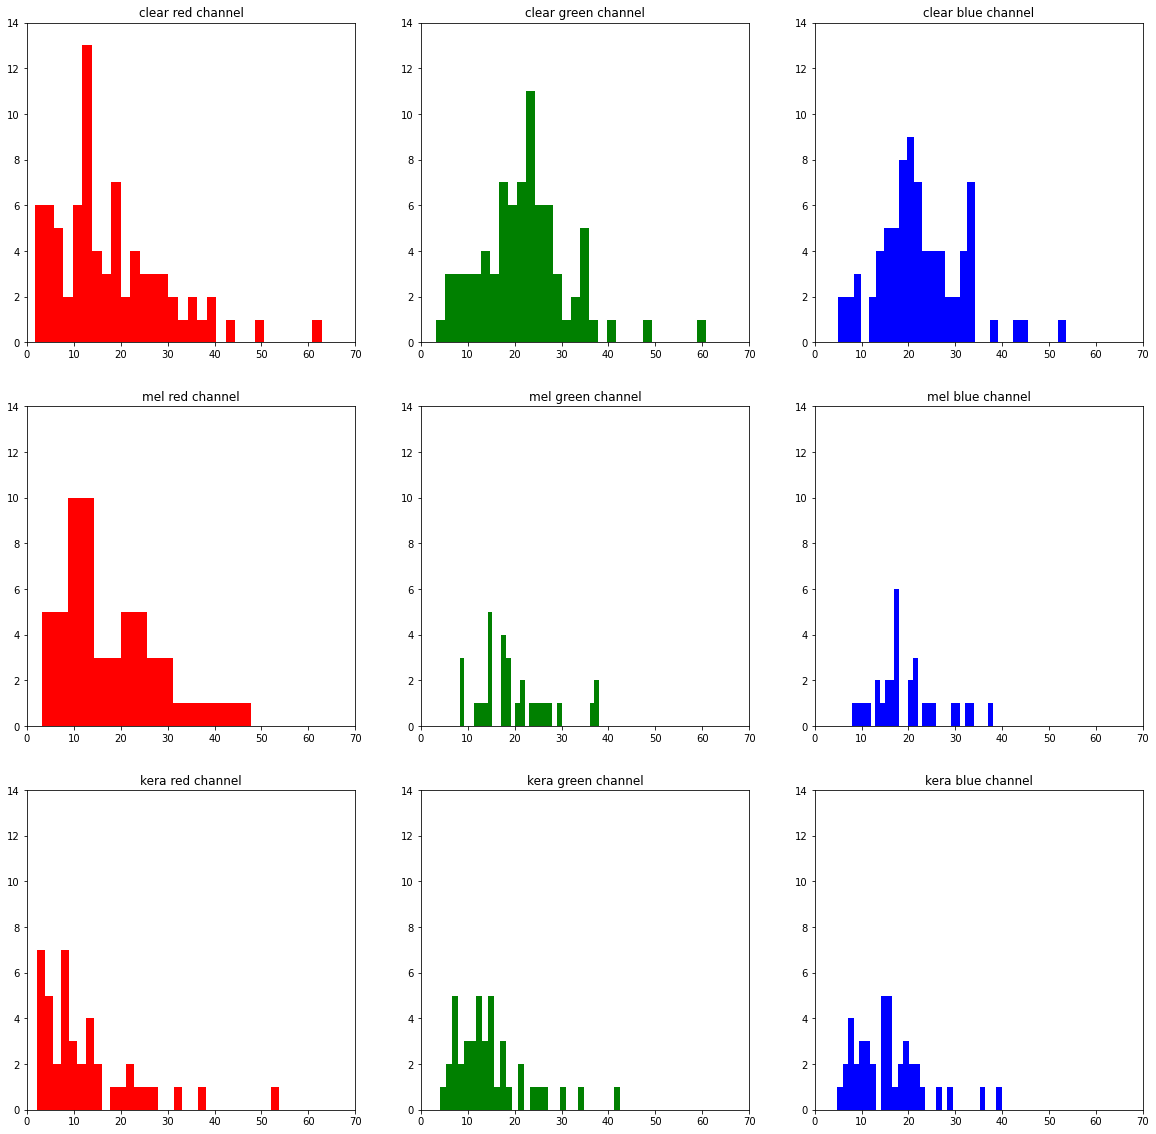

In [59]:
mel = rgb_truth[rgb_truth['melanoma']==1.0]
kera = rgb_truth[rgb_truth['seborrheic_keratosis']==1.0]
clear = rgb_truth[(rgb_truth['melanoma']==0.0) & (rgb_truth['seborrheic_keratosis']==0.0)]
                  
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
axes = axes.flatten()
b = 30
d = False
axes[0].hist(clear['r'], bins=b, color='red', density=d)
axes[1].hist(clear['g'], bins=b,color='green', density=d)
axes[2].hist(clear['b'], bins=b,color='blue', density=d);

axes[3].hist(mel['r'], bins=b,color='red', density=d)
axes[4].hist(mel['g'], bins=b,color='green', density=d)
axes[5].hist(mel['b'], bins=b,color='blue', density=d);

axes[6].hist(kera['r'], bins=b,color='red', density=d)
axes[7].hist(kera['g'], bins=b,color='green', density=d)
axes[8].hist(kera['b'], bins=b,color='blue', density=d);

axes[0].set_title('clear red channel')
axes[1].set_title('clear green channel')
axes[2].set_title('clear blue channel')

axes[3].set_title('mel red channel')
axes[4].set_title('mel green channel')
axes[5].set_title('mel blue channel')

axes[6].set_title('kera red channel')
axes[7].set_title('kera green channel')
axes[8].set_title('kera blue channel');

for i in range(9):
    axes[i].set_ylim([0,14])
    axes[i].set_xlim(0,70);

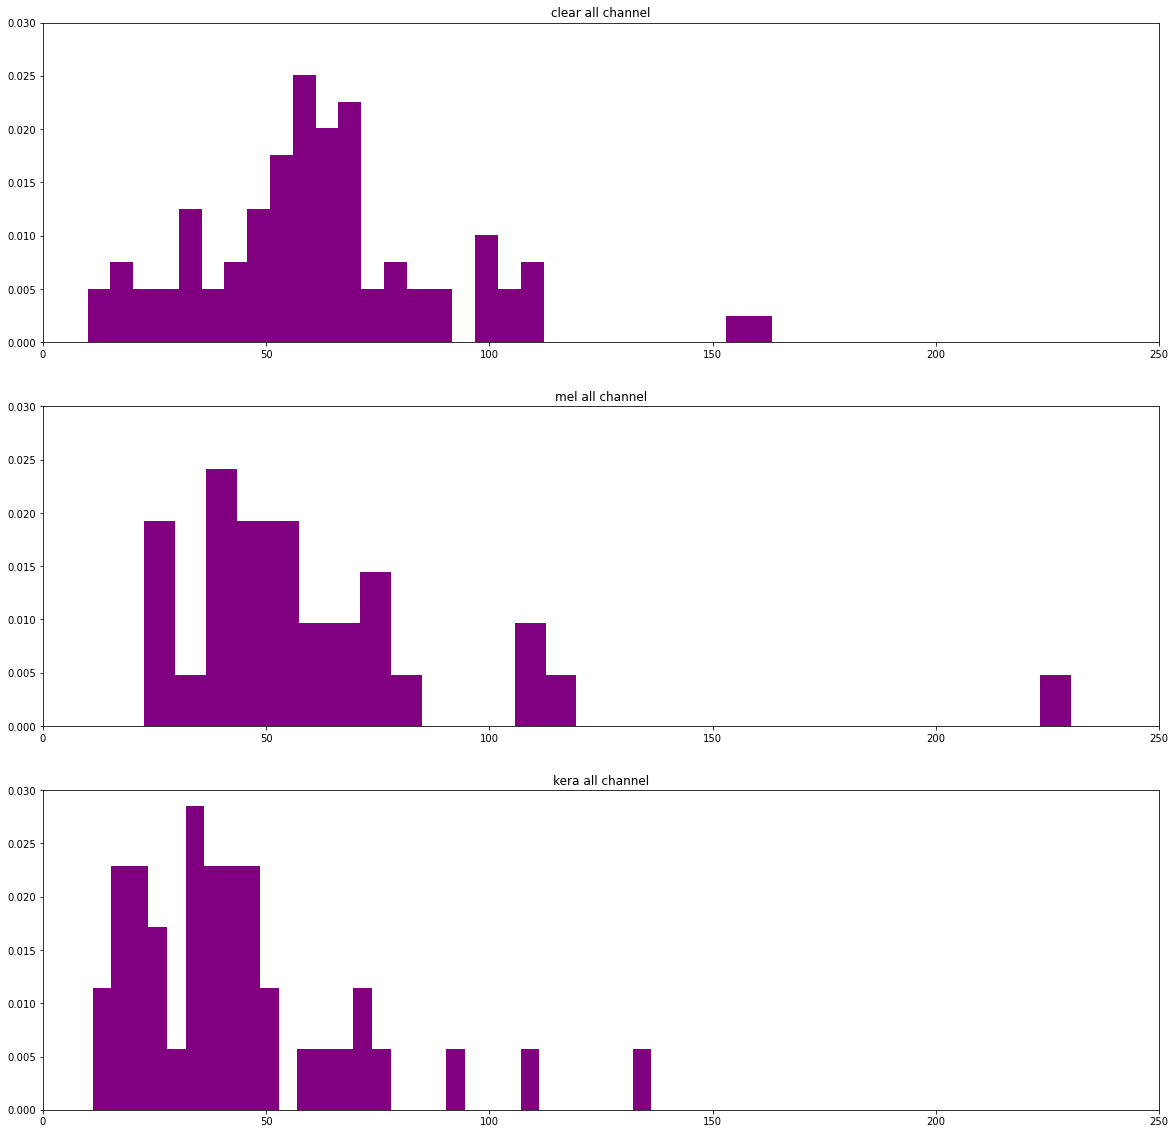

In [72]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))
axes = axes.flatten()
b = 30
d = True
axes[0].hist(clear['t'], bins=b, color='purple', density=d)

axes[1].hist(mel['t'], bins=b,color='purple', density=d)

axes[2].hist(kera['t'], bins=b,color='purple', density=d)

axes[0].set_title('clear all channel')
axes[1].set_title('mel all channel')
axes[2].set_title('kera all channel');

for i in range(3):
    axes[i].set_ylim([0,0.03])
    axes[i].set_xlim(0,250);

In [ ]:
#area = pi *r**2